In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.1')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

# Univariate Gaussian

In [9]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

loc = 5
scale = 20
data = torch.tensor(np.random.normal(loc=loc, scale=scale, size=1000))

loc = 5
scale = 20
data = torch.tensor(np.random.normal(loc=loc, scale=scale, size=1000))

def model(loc_prior_params, scale_prior_params, data):
    loc = pyro.sample("loc", dist.Normal(loc_prior_params[0], loc_prior_params[1]))
    scale = pyro.sample("scale", dist.Gamma(scale_prior_params[0], scale_prior_params[1]))
    with pyro.plate("data", 1000):
        return pyro.sample("obs", dist.Normal(loc, scale), obs=data)

# pyro.render_model(model, model_args=([0.,4.], [1., 8.], data), render_params=True, render_distributions=True)

In [3]:
def parametrised_guide(loc_prior_params, scale_prior_params, data):
    mu_mu = pyro.param("mu_mu", torch.tensor(float(loc_prior_params[0])))
    
    mu_std = pyro.param(
        "mu_std", torch.tensor(float(loc_prior_params[1])), constraint=constraints.positive
    )
    
    std_a = pyro.param(
        "std_a", torch.tensor(scale_prior_params[0]), constraint=constraints.positive
    )
    
    std_b = pyro.param(
        "std_b", torch.tensor(scale_prior_params[1]), constraint=constraints.positive
    )

    loc = pyro.sample("loc", dist.Normal(mu_mu, mu_std))
    scale = pyro.sample("scale", dist.Normal(std_a, std_b))
    return pyro.sample("data_dist", dist.Normal(loc, scale))

### Train

C:\Users\ryant\anaconda3\lib\site-packages\pyro\util.py:291: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'data_dist'}
  guide_vars - aux_vars - model_vars
Elbo loss: 6142.452677633746
Elbo loss: 4472.90082233172
Elbo loss: 4470.2476628203485
Elbo loss: 4450.270240564545
Elbo loss: 4450.7917282296585
Elbo loss: 4449.99141985989
Elbo loss: 4450.02951936009
Elbo loss: 4450.813327689761
Elbo loss: 4452.039200870926
Elbo loss: 4450.092685545786


Wall time: 3.91 s


Text(0, 0.5, 'ELBO loss')

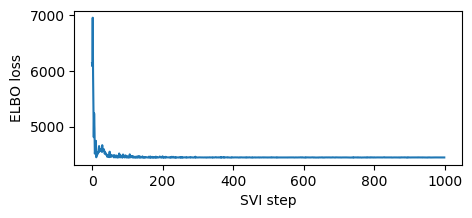

In [4]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
svi = pyro.infer.SVI(
    model=model,
    guide=parametrised_guide,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO())

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step([0,10], [8, 1], data)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [5]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

mu_mu 5.5637116
mu_std 0.69525486
std_a 20.262835
std_b 0.45077208


### Multivariate Gaussian
#### Generalise the above the above code to be for a multivariate normal



In [83]:
# make a function to generate multivariate random data 

def multivar_random(size, normal_params, gamma_params, num_samples):   

    # simulate some random means
    mu_vector = torch.tensor(np.random.normal(normal_params[0], normal_params[1], size=size))

    # simulate a random covariance matrix (PSD)
    mat = np.random.gamma(gamma_params[0], gamma_params[1], size=size**2).reshape((size, size))
    sigma_mat = torch.tensor(np.dot(mat, mat.transpose()))

    # now simulate multivariate gaussian
    data = torch.tensor(np.random.multivariate_normal(mu_vector, sigma_mat, size=num_samples))
    
    return(data, mu_vector, sigma_mat)


In [84]:
# define the model:

def model(loc_mean_prior_params, loc_scale_prior_params, data):
    loc = pyro.sample("loc", dist.MultivariateNormal(loc_mean_prior_params, loc_scale_prior_params))
    # for now leave the scale as the identity - can change it to Wishart in the future
    scale = pyro.param("scale", torch.eye(5, 5))
    with pyro.plate("data", 1000):
        return pyro.sample("obs", dist.MultivariateNormal(loc, scale), obs=data)

In [87]:
def parametrised_guide(loc_mean_prior_params, loc_scale_prior_params, data):
    
    mu_mu = pyro.param("mu_mu", torch.tensor(loc_mean_prior_params))
    
    mu_std = pyro.param(
        "mu_std", torch.tensor(loc_scale_prior_params) , constraint=constraints.positive_definite
    ) 

    loc = pyro.sample("loc", dist.MultivariateNormal(mu_mu, mu_std))
    scale = pyro.param("scale", torch.eye(5, 5))
    return pyro.sample("data_dist", dist.MultivariateNormal(loc, scale))

C:\Users\ryant\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ryant\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
Elbo loss: 736680.9620189667
Elbo loss: 97961.75460004807
Elbo loss: 61102.03262710571
Elbo loss: 43959.351459503174
Elbo loss: 25484.74414539337
Elbo loss: 18894.487701416016
Elbo loss: 15830.968316078186
Elbo loss: 14573.584770202637
Elbo loss: 12862.315815448761
Elbo loss: 11857.556167602539


Wall time: 5.67 s


Text(0, 0.5, 'ELBO loss')

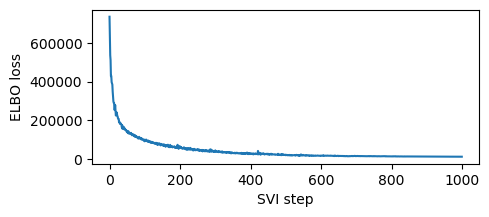

In [88]:
%%time
pyro.clear_param_store()

data, mu_vector, sigma_mat = multivar_random(5, [0, 10], [1, 1], 1000)

# These should be reset each training loop.
svi = pyro.infer.SVI(
    model=model,
    guide=parametrised_guide,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO())

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(torch.zeros(5), torch.eye(5, 5), data)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [89]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

mu_mu [ 6.3420777 31.956497   5.775317  -2.9689736 -8.357669 ]
mu_std [[ 8.3462652e-03  3.6307308e-03  7.4797347e-03  2.2098648e-03
   1.8402755e-03]
 [ 3.6307308e-03  7.7084757e-02  2.2343740e-02  2.8728142e-03
  -3.7773822e-03]
 [ 7.4797347e-03  2.2343740e-02  1.3423044e-02  3.8641153e-03
  -7.7672256e-04]
 [ 2.2098648e-03  2.8728142e-03  3.8641153e-03  3.5592555e-03
  -9.3200098e-05]
 [ 1.8402755e-03 -3.7773822e-03 -7.7672256e-04 -9.3200098e-05
   3.3165454e-03]]
scale [[ 8.594566    0.4329217   5.226013    1.307479    3.2501667 ]
 [ 0.4329217   8.174869    2.607416    0.20056503 -0.06580348]
 [ 5.226013    2.607416    4.886437    1.4126663   0.9534494 ]
 [ 1.307479    0.20056503  1.4126663   2.2653964  -1.0579343 ]
 [ 3.2501667  -0.06580348  0.9534494  -1.0579343   4.182953  ]]


In [90]:
mu_vector

tensor([ 6.4560, 34.9418,  6.7597, -2.9077, -8.4746], dtype=torch.float64)

In [91]:
sigma_mat

tensor([[20.2170,  8.1435, 13.5323,  1.3032, 10.3329],
        [ 8.1435, 10.9987,  8.4726,  1.7492,  4.4068],
        [13.5323,  8.4726, 10.8561,  1.1566,  7.0430],
        [ 1.3032,  1.7492,  1.1566,  0.9284,  0.9030],
        [10.3329,  4.4068,  7.0430,  0.9030,  5.4539]], dtype=torch.float64)